In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
import numpy as np
from math import radians, cos, sin, asin, sqrt
from copy import deepcopy 
from scipy.stats import norm, kurtosis
import random

In [3]:

df = pd.read_csv('sites.csv') #read the data from the csv as a pandas dataframe
dists = np.load('dists.npy')

DETERMINISTIC = True

def Fair(quant_demanded):
    if len(quant_demanded) == 0:
        return 0
    
    num = sum(quant_demanded)**2
    denom = len(quant_demanded)*sum([i*i for i in quant_demanded])

    # print("DEBUG:" + " len is "+ str(len(quant_demanded)))
    # print("DEBUG:" + "sum of sqs is " + str(sum([i*i for i in quant_demanded])))
    return num/denom

def runsite(demand):
    demand = int(demand)
    ppl_food_quantity = []      # initialize array of X_i's for ppl's quanitity in lbs for 2 weeks
    if DETERMINISTIC:
        kids = int(round(.41*demand))
        adults = int(round(.4*demand))
        seniors = demand - kids - adults
        ppl_food_quantity = [70]*kids + [56]*adults + [42]*seniors    

    for i in range(0,demand):  # for each person at a site
        if sum(ppl_food_quantity)>15000:
            ppl_food_quantity.append(0)
        else:
            x = random.random()
            if x<= 0.41:     # the person is a child
                ppl_food_quantity.append(5*14)         # 5 lbs of food per day
            elif x <= 0.81:       # the person is an adult
                ppl_food_quantity.append(4*14)         # 4lbs of food a day
            else:                    # the person is a senior
                ppl_food_quantity.append(3*14)       # 3lbs of food a day
    # quantitative meansurement of fairness
    fairness_val = Fair(ppl_food_quantity)

    if 0 not in ppl_food_quantity:
        max_ppl_srvd = demand
    else:
        max_ppl_srvd = ppl_food_quantity.index(0)
    return fairness_val, max_ppl_srvd


stdevs = np.array((df['StDev(Demand per Visit)']))
variance = stdevs**2
stdevs = np.sqrt(np.matmul(variance,dists))
demands = np.array((df['Average Demand per Visit']))
increment = np.matmul(demands/28, dists) #how much demand increases every day
schedules = []
demandDist = []
fairnesslevels = []

nvisits = np.zeros(70)

factorincrements = 100
maxfactor = 20
inc = maxfactor/factorincrements
factor = 0

if DETERMINISTIC:
    ntrials = 1
else:
    ntrials = 2

while factor <= maxfactor:
    #print(factor)
    totalexcess = 0

    thislevelschedules = []
    
    for k in range(ntrials):
        optimal = [] #empty list for schedule

        demands = np.array((df['Average Demand per Visit']))
        daysElapsed = [0] * 70
        optimal = []
        excessdemand = 0
        isFair = []
        for day in range(365):

            fx = [factor*x for x in daysElapsed]

            demands = demands + fx
            a = deepcopy(demands)
            a = np.sort(a)

            first = a[-1]
            index1 = np.where(demands == first)

            second = a[-2]
            index2 = np.where(demands == second)

            demands = demands - fx
            
            if DETERMINISTIC:
                demand1 = demands[index1]
                demand2 = demands[index2]
            else:
                demand1 = random.normalvariate(demands[index1],stdevs[index1])
                demand2 = random.normalvariate(demands[index2],stdevs[index2])
                demand1 = max(0,demand1)
                demand2 = max(0,demand2)
                
            fair1, maxsrvd1 = runsite(demand1)
            fair2, maxsrvd2 = runsite(demand2)

            isFair.append(fair1)
            isFair.append(fair2)
            
            demands = (demands - min(demand1,maxsrvd1)*dists[index1])[0]
            demands = (demands - min(demand2,maxsrvd2)*dists[index2])[0]

            daysElapsed = [i + 1 for i in daysElapsed]
            daysElapsed[int(index1[0])] = 0
            daysElapsed[int(index2[0])] = 0

            optimal.append([int(index1[0]),int(index2[0])])
            nvisits[index1] += 1
            nvisits[index2] += 1

            demands = [0 if x<0 else x for x in demands]
            demands = demands + increment
            excessdemand += sum(demands)

        totalexcess += excessdemand
        thislevelschedules.append(optimal)
        fairness = sum(isFair)
        
    schedules.append(thislevelschedules)
    fairnesslevels.append(fairness)
    demandDist.append(totalexcess/(365*ntrials))
    
    factor += inc

print(demandDist)
print(fairnesslevels)

[7500.301737809537, 7358.884171433087, 7243.858869873245, 7165.0335578404765, 7112.95692194683, 7079.437566178106, 7052.469217422114, 7026.461254227871, 7007.562259257261, 6995.551516034174, 6988.857165970948, 6990.171456751212, 6986.7598697405165, 6982.34124363752, 6980.451686395498, 6985.409628885667, 6990.534095557641, 6994.068389994976, 6997.1042163306365, 7005.500219354059, 7013.720933640797, 7020.37807605766, 7022.573835255332, 7026.31612832168, 7030.951491486553, 7042.436473032428, 7045.627094707752, 7057.11780698139, 7065.057624783111, 7073.433278761189, 7077.439130299275, 7088.9822795765995, 7092.383134567069, 7097.7142664597195, 7107.672986318389, 7119.739056065513, 7124.103010342849, 7131.106383182296, 7145.600663348397, 7144.353561067775, 7151.959661497474, 7161.378412322972, 7164.245827595769, 7170.3666528071035, 7176.74515200335, 7181.333095111412, 7186.988688693999, 7195.715528926267, 7200.913875706522, 7207.620747075897, 7213.082305820973, 7220.756746178693, 7226.826900

In [4]:
freqList = []
for level in schedules:
    freq = [0] * 70
    for trial in level:
        for day in trial:
            freq[day[0]] += 1
            freq[day[1]] += 1
    freqList.append(freq)

In [5]:
def gini(list):
    ## first sort
    arr = np.array(list)
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by our 'j' point
            if all(scores[j] < scores[i]) and any(scores[j] <= scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

def lorenz_curve(freq):
    X = np.array(freq)
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[6,6])
    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
               marker='x', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')

In [6]:
freqList[0].sort()

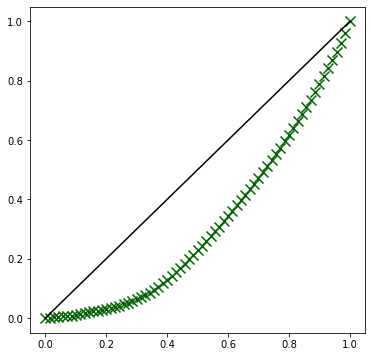

In [7]:
lorenz_curve(freqList[0])

In [8]:
fairnesslevels = [i * -1 for i in fairnesslevels]
giniList = []
for i in freqList:
    giniList.append(gini(i))
minimize = np.column_stack((demandDist, giniList, fairnesslevels))

<IPython.core.display.Javascript object>


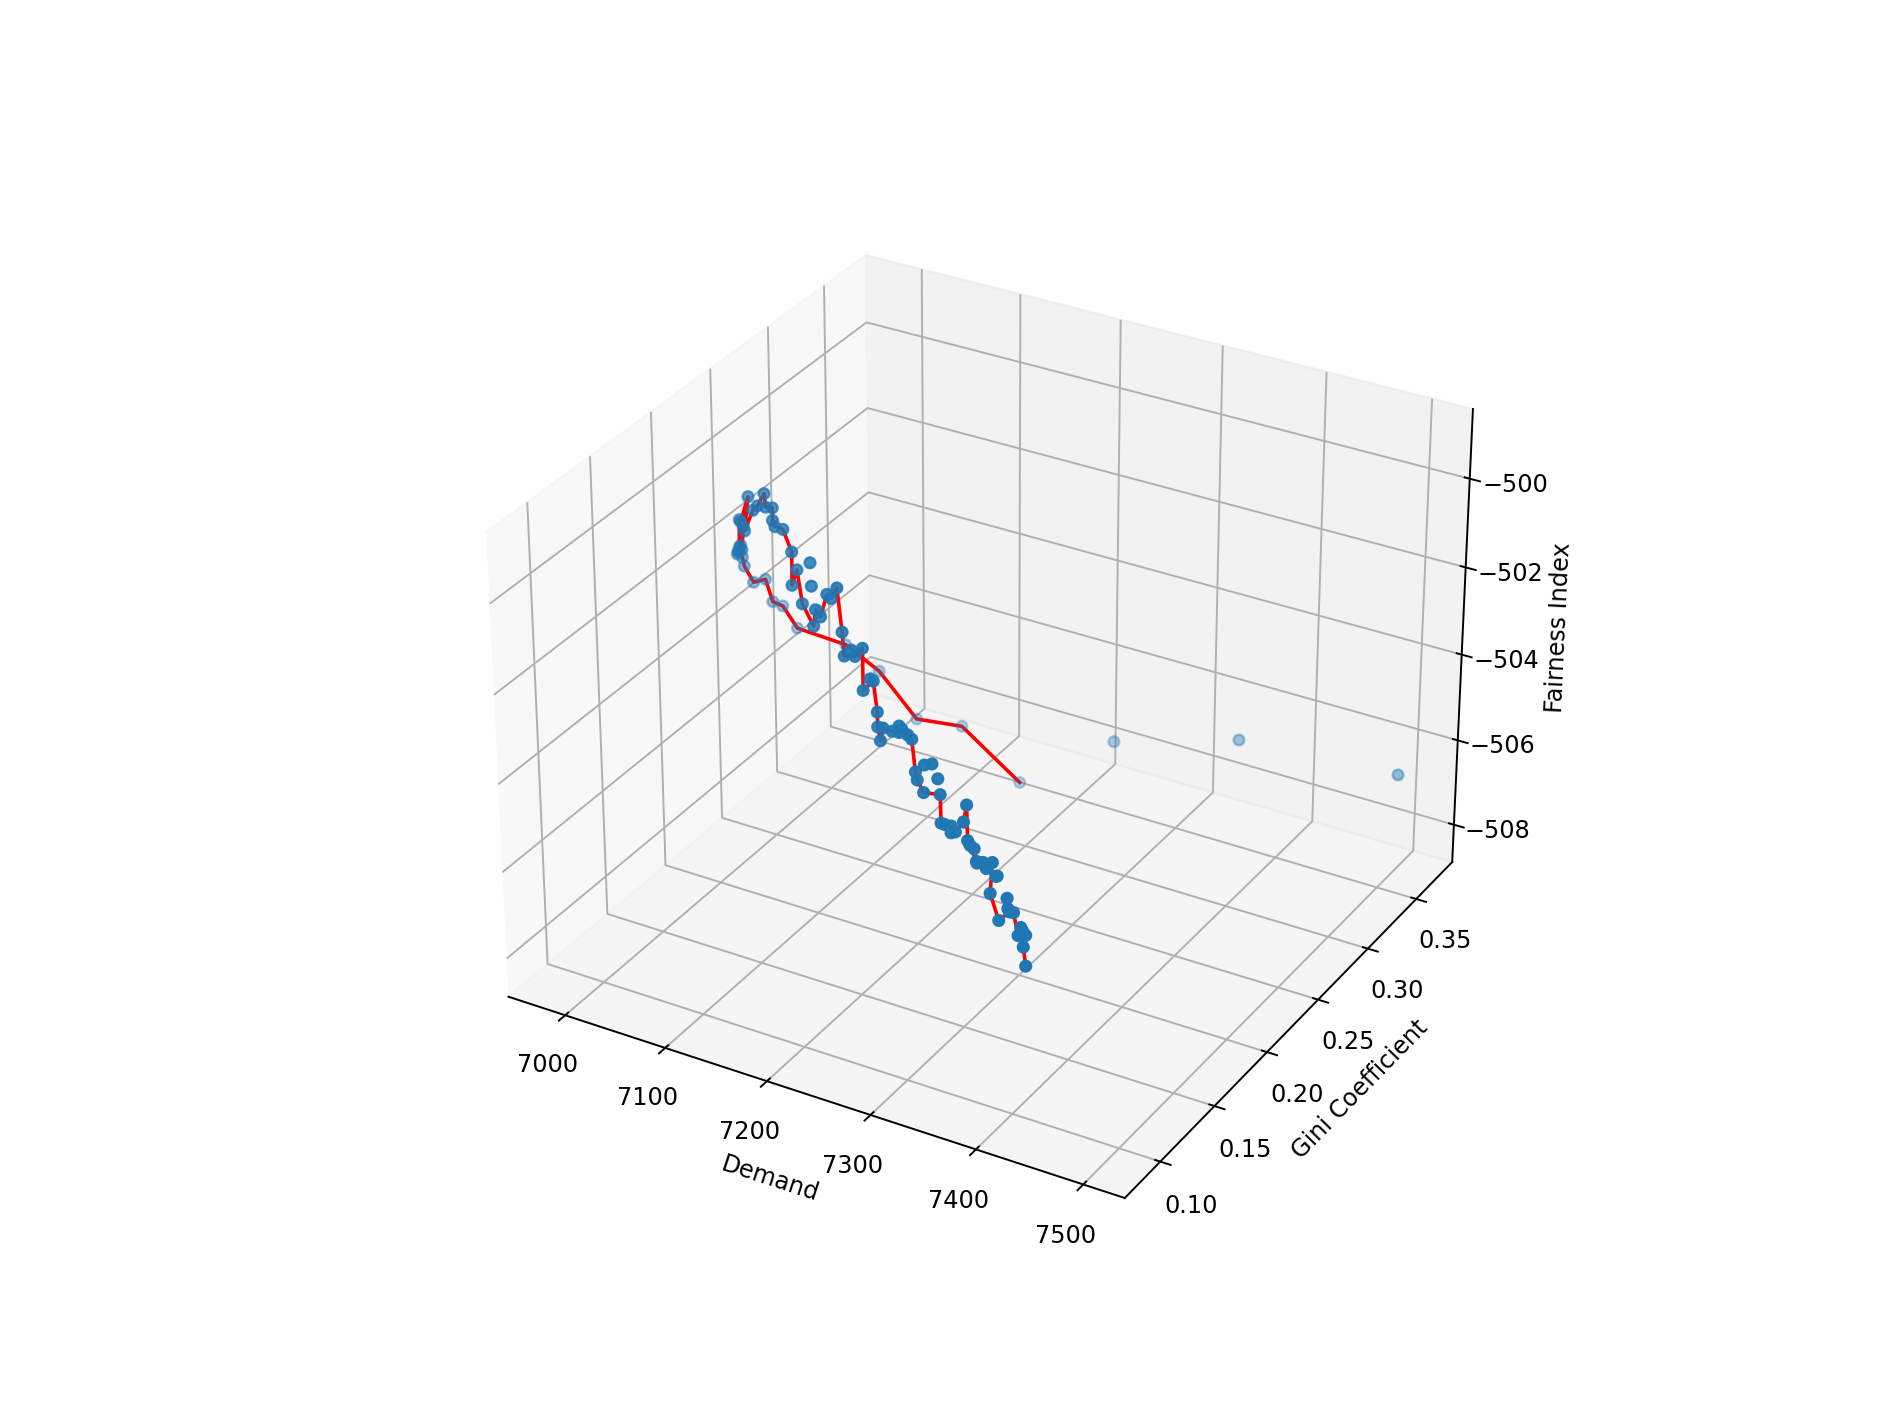

In [9]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
pareto = identify_pareto(minimize)
pareto_front = minimize[pareto]
x_all = minimize[:, 0]
y_all = minimize[:, 1]
z_all = minimize[:, 2]
x_pareto = pareto_front[:, 0]
y_pareto = pareto_front[:, 1]
z_pareto = pareto_front[:, 2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_all, y_all, z_all)
ax.plot(x_pareto, y_pareto, z_pareto, color='r')
ax.set_xlabel('Demand')
ax.set_ylabel('Gini Coefficient')
ax.set_zlabel('Fairness Index')
plt.show()

In [10]:
def con_max(priorities, demand, leftover):
    index = -1
    for i in range(len(priorities)):
        if priorities[i] > priorities[index] and demand[i] <= leftover:
            index = i
    return index

In [11]:
countList = []
for schedule in schedules:
    for i in schedule:
        freq = [0] * 70
        for j in i:
            freq[j[0]] += 1
            freq[j[1]] += 1
        countList.append(freq)

In [12]:
def locate_min(a):
    smallest = min(a)
    return [index for index, element in enumerate(a) if smallest == element]
def locate_max(a):
    biggest = max(a)
    return [index for index, element in enumerate(a) if biggest == element]

In [13]:
nSchedule = []
avgDemands = df['Average Demand per Visit']
for i in schedules[0]:
    for j in i:
        daily = []
        for k in j:
            leftover = 300 -(avgDemands[k] + df['StDev(Demand per Visit)'][k])
            if leftover >= min(avgDemands):
                rare = locate_min(countList[0])
                rare_demand = []
                for i in rare:
                    rare_demand.append(avgDemands[i])
                second = locate_max(rare_demand)
                visit = avgDemands[avgDemands == rare_demand[second[0]]]
                index = int(visit.index.tolist()[0])
                daily.append([k, index])
                countList[0][index] += 1
            else:
                daily.append([k, -1])
        nSchedule.append(daily)
        
nSchedule

[[[65, -1], [1, -1]],
 [[16, -1], [2, -1]],
 [[27, -1], [31, -1]],
 [[61, -1], [12, -1]],
 [[10, -1], [29, -1]],
 [[21, 38], [30, -1]],
 [[5, 48], [28, 45]],
 [[4, 54], [0, 59]],
 [[64, 60], [67, 50]],
 [[68, 58], [63, 40]],
 [[33, 47], [9, 37]],
 [[20, 35], [25, 44]],
 [[69, 55], [17, 49]],
 [[1, -1], [3, 38]],
 [[7, 48], [8, 45]],
 [[65, -1], [32, 54]],
 [[13, 59], [18, 60]],
 [[22, 53], [14, 43]],
 [[23, 50], [34, 58]],
 [[11, 40], [31, -1]],
 [[66, 47], [2, -1]],
 [[16, -1], [27, -1]],
 [[19, 37], [12, -1]],
 [[30, -1], [62, 35]],
 [[61, -1], [15, 44]],
 [[10, -1], [21, 55]],
 [[26, 49], [39, 38]],
 [[29, -1], [24, 48]],
 [[65, -1], [28, 45]],
 [[1, -1], [64, 54]],
 [[68, 59], [6, 60]],
 [[9, 46], [5, 52]],
 [[4, 51], [67, 53]],
 [[0, 43], [63, 50]],
 [[66, 58], [31, -1]],
 [[8, 40], [69, 47]],
 [[20, 37], [33, 35]],
 [[25, 44], [16, -1]],
 [[2, -1], [27, -1]],
 [[17, 55], [12, -1]],
 [[65, -1], [3, 49]],
 [[7, 38], [30, -1]],
 [[61, -1], [15, 48]],
 [[1, -1], [42, 45]],
 [[22, 54]

In [ ]:
foodMap = fm.Map(location=[42.3, -76.5], tiles='Stamen Toner', zoom_start = 9.2)
coordinates = df[['latitude', 'longitude']]
coordinateList = coordinates.values.tolist()
print(coordinateList)
for element in coordinateList:
    fm.CircleMarker(element, radius=3, color='blue', opacity=0.3).add_to(foodMap)
foodMap